## Predicting Student Success Rate
Used Tutorial for PCA guidance from https://www.jcchouinard.com/pca-with-python/

Steps:
- Visualize and understand data

In [6]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.font_manager as fm
import missingno as msno
from sklearn import decomposition
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, balanced_accuracy_score
from mlxtend.evaluate import bias_variance_decomp

# Data Validaiton
Read the CSV file, view available features, and validate the data.

In [7]:
df = pd.read_csv('data.csv', sep=';')
df.head(3)

,Marital status,Application mode,Application order,Course,Daytime/evening attendance\t,Previous qualification,Previous qualification (grade),Nacionality,Mother's qualification,Father's qualification,...,Curricular units 2nd sem (credited),Curricular units 2nd sem (enrolled),Curricular units 2nd sem (evaluations),Curricular units 2nd sem (approved),Curricular units 2nd sem (grade),Curricular units 2nd sem (without evaluations),Unemployment rate,Inflation rate,GDP,Target
0,1,17,5,171,1,1,122.0,1,19,12,...,0,0,0,0,0.000000,0,10.8,1.4,1.74,Dropout
1,1,15,1,9254,1,1,160.0,1,1,3,...,0,6,6,6,13.666667,0,13.9,-0.3,0.79,Graduate
2,1,1,5,9070,1,1,122.0,1,37,37,...,0,6,0,0,0.000000,0,10.8,1.4,1.74,Dropout


<AxesSubplot:>

/Users/alik/opt/miniconda3/lib/python3.9/site-packages/IPython/core/events.py:89: UserWarning: Glyph 9 (	) missing from current font.
  func(*args, **kwargs)
/Users/alik/opt/miniconda3/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


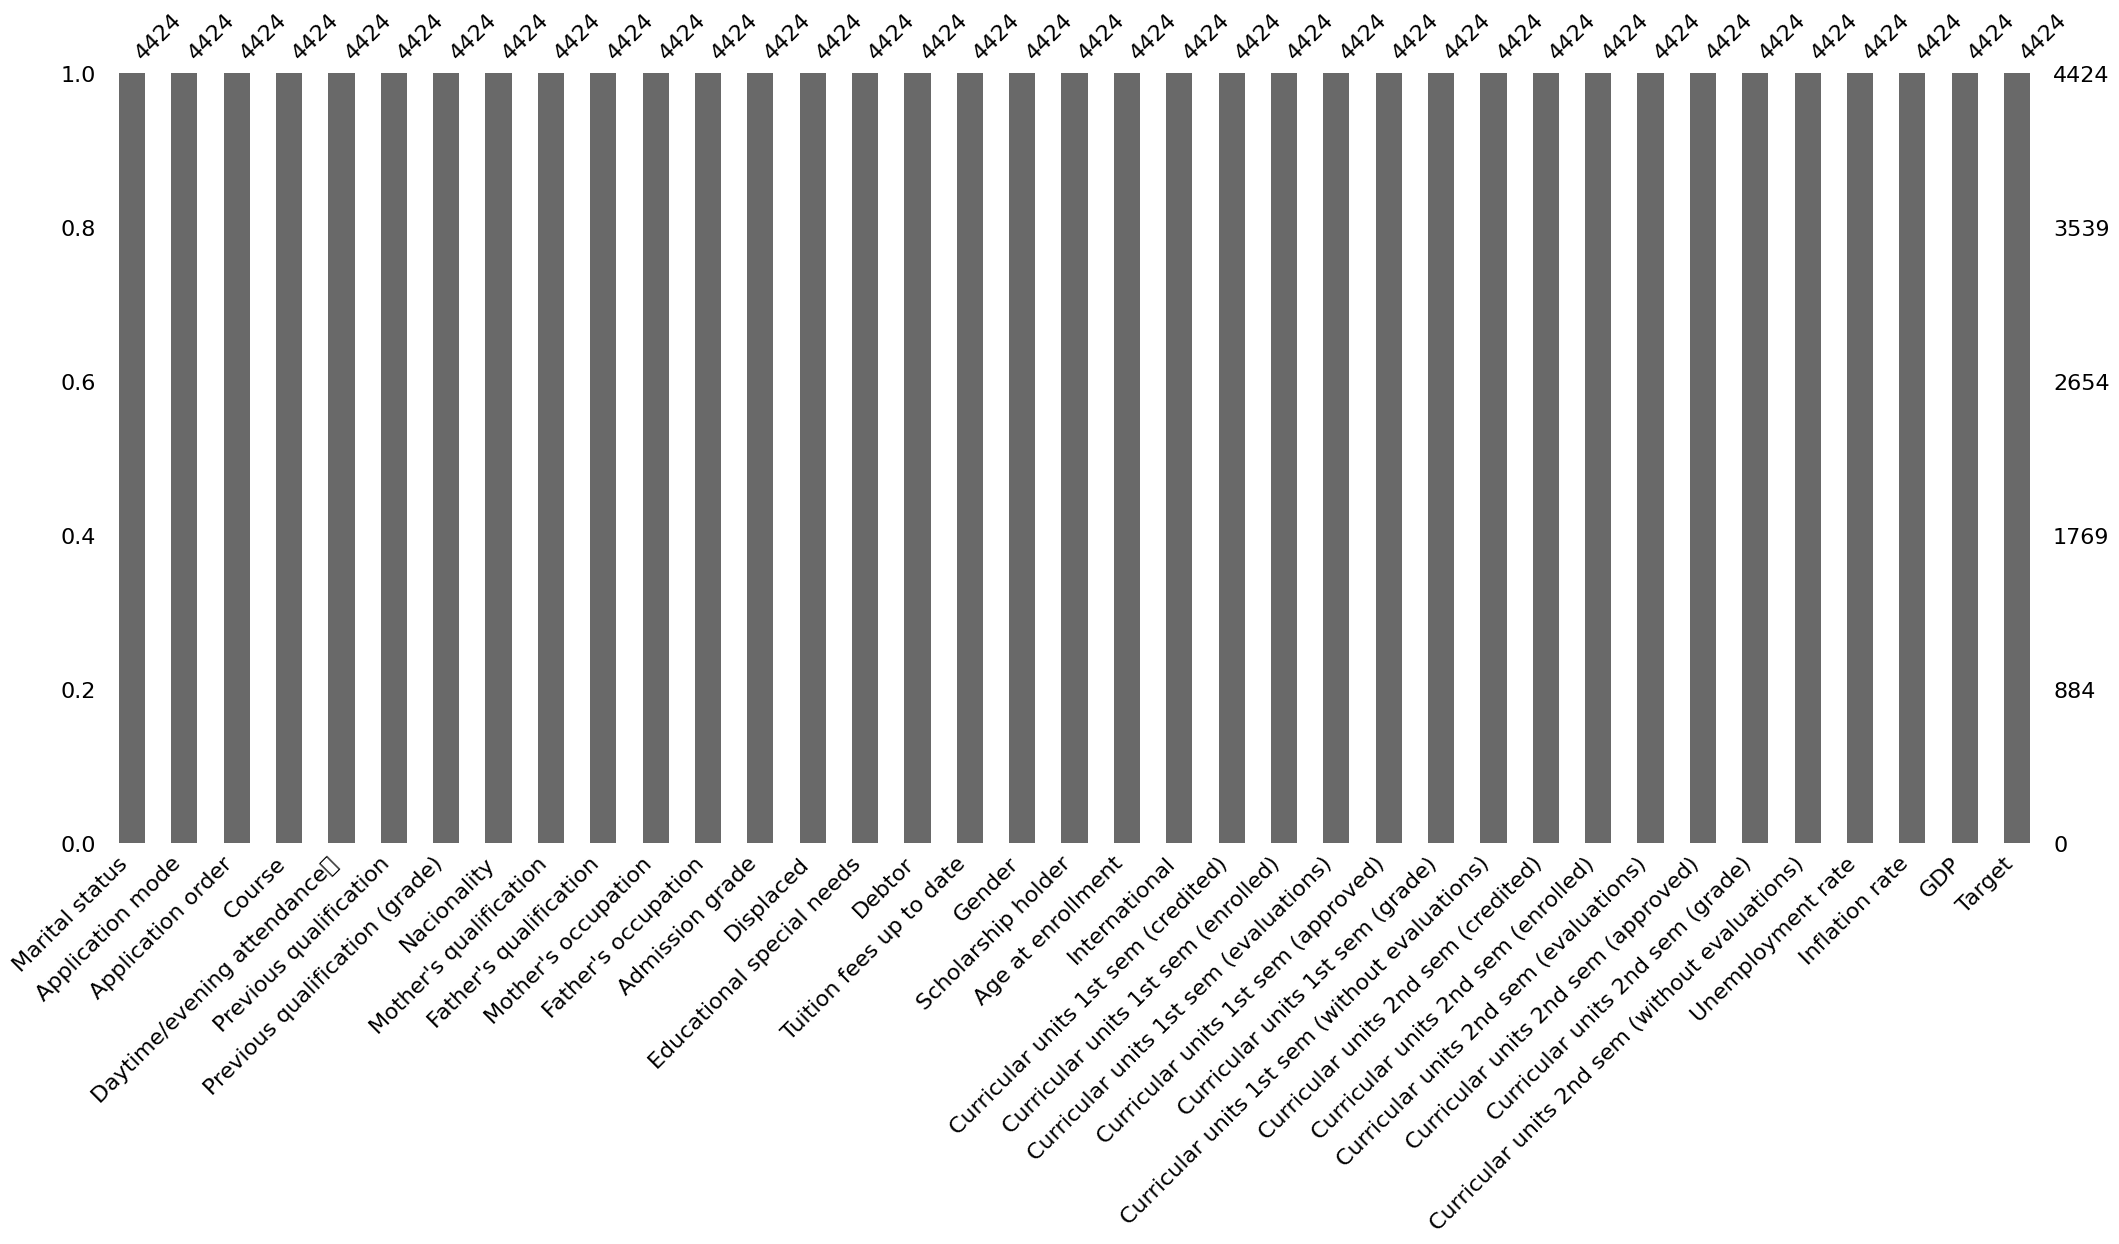

In [8]:
# Missing data detection
msno.bar(df)

We can see that there are no null entries as all the columns are equally populated and there are no missing values for each column.
We can also check that we have a good ratio of dropout to graduate/enrolled students so we can train our model properly.

In [9]:
df_arr = df.to_numpy()
num_dropouts = np.sum(df_arr[:,-1] == "Dropout")
print("Number of dropout data points: " + str(num_dropouts))
print("Number of total data points: " + str(len(df_arr)))
print("Ratio of droupout to total data points: " + str(num_dropouts / len(df_arr))[0:5])

Number of dropout data points: 1421
Number of total data points: 4424
Ratio of droupout to total data points: 0.321


# Splitting Data
Now we split the data into 80/20 training and testing groups.

In [10]:
n_train = np.floor(0.8*4224).astype(int)
train_data = df_arr[0:n_train, :]
test_data = df_arr[n_train:, :]
print('Training Data Points: ', train_data.shape[0])
print('Testing Data Points: ', test_data.shape[0])

Training Data Points:  3379
Testing Data Points:  1045


In [13]:
# Create X matrix and y vector
X_train = train_data[:, :-1]
X_train = StandardScaler().fit_transform(X_train) # Standardizes features with 0 mean and unit variance
y_train = train_data[:, -1]
display(y_train)

# Reformat label with dropout as 0 and graduate or enrolled as 1
target_dict = {'Dropout': 0, 'Graduate': 1, 'Enrolled':1}
target_names = {0:'Dropout', 1:'Graduate or Enrolled'}
y_train = np.array([target_dict[val] for val in y_train])
print(y_train)

array(['Dropout', 'Graduate', 'Dropout', ..., 'Graduate', 'Graduate',
       'Enrolled'], dtype=object)

[0 1 0 ... 1 1 1]


# Dimensionality reduction

Next, use Principal Component Analysis (PCA) for dimensionality reduction.
First we'll try reducing the 36 original features down to 10.

Shape before PCA:  (3379, 36)
Shape after PCA:  (3379, 10)


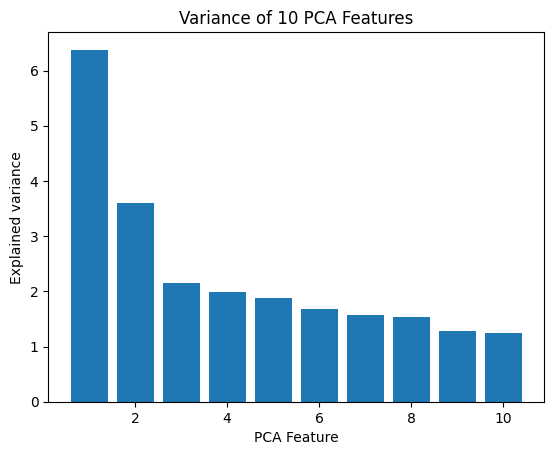

In [14]:
# PCA With 10 Features
pca_10 = decomposition.PCA(n_components=10)
pca_10.fit(X_train)
X_10 = pca_10.transform(X_train)
print('Shape before PCA: ', X_train.shape)
print('Shape after PCA: ', X_10.shape)

# Determine variance of the 10 Principal Components (PCs) created by PCA
pca_10.explained_variance_
plt.bar(range(1, len(pca_10.explained_variance_) + 1), pca_10.explained_variance_)
plt.xlabel('PCA Feature')
plt.ylabel('Explained variance')
plt.title('Variance of 10 PCA Features')
plt.show()

From this, we can see that the first 2 features seem to be the most informative, so let's perform PCA with 2 features

In [15]:
# PCA With 2 Features
pca_2 = decomposition.PCA(n_components=2)
pca_2.fit(X_train)
X_2 = pca_2.transform(X_train)
print('Shape before PCA: ', X_train.shape)
print('Shape after PCA: ', X_2.shape)

Shape before PCA:  (3379, 36)
Shape after PCA:  (3379, 2)


Now lets plot the data after PCA

           PC1       PC2                target
0    -6.130470 -0.228367               Dropout
1    -0.229564 -1.095423  Graduate or Enrolled
2    -3.956740  0.474827               Dropout
3     0.441241 -0.955101  Graduate or Enrolled
4     0.416296  2.760972  Graduate or Enrolled
...        ...       ...                   ...
3374  0.035069 -1.655037  Graduate or Enrolled
3375  1.255393  0.396772  Graduate or Enrolled
3376  0.414905 -1.667482  Graduate or Enrolled
3377  0.807560 -1.160769  Graduate or Enrolled
3378 -0.659505 -0.328269  Graduate or Enrolled

[3379 rows x 3 columns]


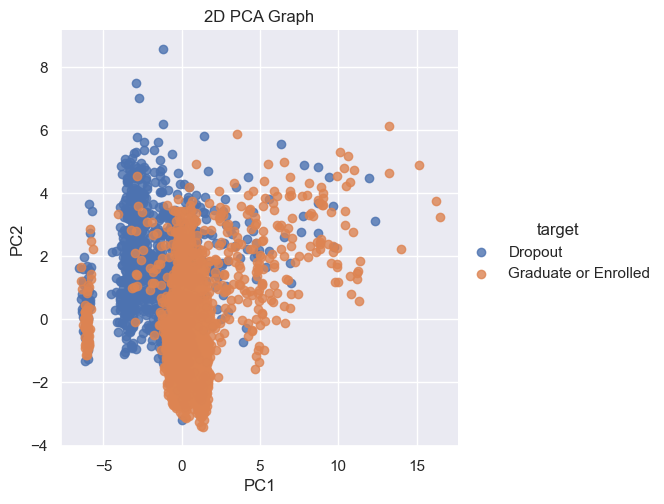

In [16]:
sns.set()
pca_df = pd.DataFrame(data=X_2, columns=['PC1', 'PC2'])
pca_df['target'] = [target_names[target] for target in y_train]
print(pca_df)

sns.lmplot(x='PC1', y='PC2', data=pca_df, hue='target', fit_reg=False, legend=True)
plt.title('2D PCA Graph')
plt.show()

Let's see how different features are being taken into account with each principal component

In [17]:
# Principal components correlation coefficients
comps = pca_2.components_
 
# Number of features before PCA
n_features = pca_2.n_features_
 
# Feature names before PCA
feature_names = df.columns[:-1]
 
# PC names
pc_list = [f'PC{i}' for i in list(range(1, n_features + 1))]
 
# Match PC names to loadings
pc_loadings = dict(zip(pc_list, comps))
 
# Matrix of corr coefs between feature names and PCs
loadings_df = pd.DataFrame.from_dict(pc_loadings)
loadings_df['feature_names'] = feature_names
loadings_df = loadings_df.set_index('feature_names')
loadings_df

/Users/alik/opt/miniconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:101: FutureWarning: Attribute `n_features_` was deprecated in version 1.2 and will be removed in 1.4. Use `n_features_in_` instead.
  warnings.warn(msg, category=FutureWarning)


,PC1,PC2
feature_names,,
Marital status,0.017437,0.251327
Application mode,0.062687,0.358227
Application order,-0.015585,-0.224460
Course,0.136009,-0.043111
Daytime/evening attendance\t,-0.014399,-0.252856
Previous qualification,0.054958,0.172141
Previous qualification (grade),-0.007507,-0.066957
Nacionality,-0.011275,-0.005938
Mother's qualification,0.012825,0.160843


# Logistic Regression
The first model we used to fite our data was logistic regression.

In [32]:
errorGraph = []
accuracyGraph = []
varianceGraph = []
biasGraph = []

pca_30 = decomposition.PCA(n_components=30)
pca_30.fit(X_train)
X_30 = pca_30.transform(X_train)

Regression With 30 Features

In [25]:
clf = LogisticRegression()
clf.fit(X_30, y_train)

LogisticRegression()

In [26]:
X_test = test_data[:, :-1]
X_test = StandardScaler().fit_transform(X_test)
X_test_30 = pca_30.transform(X_test)
y_test = [target_dict[val] for val in test_data[:, -1]]
y_pred = clf.predict(X_test_30)

In [27]:
from sklearn.metrics import explained_variance_score
explained_variance_score(y_test, y_pred)

0.39531023368251406

In [33]:
mse, bias, var = bias_variance_decomp(clf, X_30, y_train, X_test_30, np.array(y_test), loss='mse', num_rounds=200, random_seed=123)
print("MSE: " + str(mse))
print("Bias: " + str(bias))
print("Variance: " + str(var))

accuracy = balanced_accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")
print("Confusion matrix:")
print(conf_matrix)

errorGraph.append(mse)
accuracyGraph.append(accuracy)
varianceGraph.append(var)
biasGraph.append(bias)

MSE: 0.1481531100478469
Bias: 0.13578569377990432
Variance: 0.012367416267942584
Accuracy: 0.72
Confusion matrix:
[[189 176]
 [ 59 621]]


Regression With 10 Features

In [34]:
clf = LogisticRegression()
clf.fit(X_10, y_train)

X_test_10 = pca_10.transform(X_test)
y_pred = clf.predict(X_test_10)

mse, bias, var = bias_variance_decomp(clf, X_10, y_train, X_test_10, np.array(y_test), loss='mse', num_rounds=200, random_seed=123)
print("MSE: " + str(mse))
print("Bias: " + str(bias))
print("Variance: " + str(var))

accuracy = balanced_accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")
print("Confusion matrix:")
print(conf_matrix)

errorGraph.append(mse)
accuracyGraph.append(accuracy)
varianceGraph.append(var)
biasGraph.append(bias)

MSE: 0.1747751196172249
Bias: 0.16674995215311003
Variance: 0.00802516746411483
Accuracy: 0.78
Confusion matrix:
[[232 133]
 [ 46 634]]


Regression with 2 Features

In [35]:
clf = LogisticRegression()
clf.fit(X_2, y_train)

X_test_2 = pca_2.transform(X_test)
y_pred = clf.predict(X_test_2)

mse, bias, var = bias_variance_decomp(clf, X_2, y_train, X_test_2, np.array(y_test), loss='mse', num_rounds=200, random_seed=123)
print("MSE: " + str(mse))
print("Bias: " + str(bias))
print("Variance: " + str(var))

accuracy = balanced_accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")
print("Confusion matrix:")
print(conf_matrix)

errorGraph.append(mse)
accuracyGraph.append(accuracy)
varianceGraph.append(var)
biasGraph.append(bias)

MSE: 0.22426794258373206
Bias: 0.2193225837320574
Variance: 0.004945358851674641
Accuracy: 0.72
Confusion matrix:
[[189 176]
 [ 59 621]]


### Graphing error

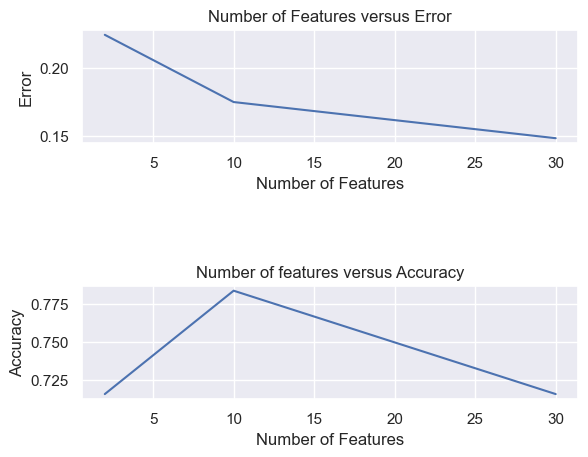

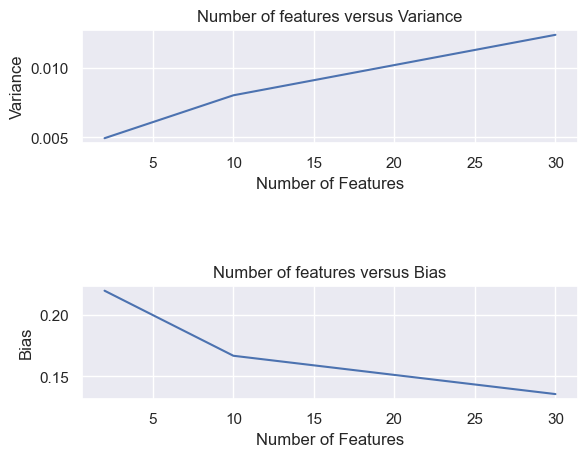

In [43]:
indices = [30, 10, 2]
fig, axs = plt.subplots(2)
axs[0].plot(indices, errorGraph)
axs[0].set_xlabel('Number of Features')
axs[0].set_ylabel('Error')
axs[0].set_title('Number of Features versus Error')

axs[1].plot(indices, accuracyGraph)
axs[1].set_xlabel('Number of Features')
axs[1].set_ylabel('Accuracy')
axs[1].set_title('Number of features versus Accuracy')
fig.subplots_adjust(hspace=1.25)

fig, axs = plt.subplots(2)
axs[0].plot(indices, varianceGraph)
axs[0].set_xlabel('Number of Features')
axs[0].set_ylabel('Variance')
axs[0].set_title('Number of features versus Variance')

axs[1].plot(indices, biasGraph)
axs[1].set_xlabel('Number of Features')
axs[1].set_ylabel('Bias')
axs[1].set_title('Number of features versus Bias')
fig.subplots_adjust(hspace=1.25)

plt.show()

As we can see as the number of features increases, variance increases and bias decreases. This means that the model is "memorizing" data during training and is unable to adapt well to new data during testing.

# Neural Net

Our next model that we tried was the neural net. Our first implementation accepted 36 inputs, had 2 hidden layers of 16 nodes and one hidden layer with 4 nodes, and made a final prediction using a sigmoid activation function.

In [87]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LeakyReLU

errorGraph = []
accuracyGraph = []
model_1 = Sequential()
model_1.add(Dense(16, input_dim=36))
model_1.add(LeakyReLU(alpha=0.05))
model_1.add(Dense(16, input_dim=16))
model_1.add(LeakyReLU(alpha=0.05))
model_1.add(Dense(4, input_dim=16))
model_1.add(LeakyReLU(alpha=0.05))
model_1.add(Dense(1, activation='sigmoid'))

model_1.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
history_1 = model_1.fit(X_train, y_train, validation_split=0.1, epochs=50, batch_size=400)

Epoch 1/50
8/8 [==============================] - 2s 81ms/step - loss: 0.6940 - accuracy: 0.5919 - val_loss: 0.6577 - val_accuracy: 0.6627
Epoch 2/50
8/8 [==============================] - 0s 14ms/step - loss: 0.6633 - accuracy: 0.6705 - val_loss: 0.6340 - val_accuracy: 0.7219
Epoch 3/50
8/8 [==============================] - 0s 14ms/step - loss: 0.6368 - accuracy: 0.7310 - val_loss: 0.6096 - val_accuracy: 0.7544
Epoch 4/50
8/8 [==============================] - 0s 18ms/step - loss: 0.6102 - accuracy: 0.7583 - val_loss: 0.5846 - val_accuracy: 0.7663
Epoch 5/50
8/8 [==============================] - 0s 9ms/step - loss: 0.5833 - accuracy: 0.7803 - val_loss: 0.5583 - val_accuracy: 0.7840
Epoch 6/50
8/8 [==============================] - 0s 7ms/step - loss: 0.5551 - accuracy: 0.7938 - val_loss: 0.5319 - val_accuracy: 0.7781
Epoch 7/50
8/8 [==============================] - 0s 8ms/step - loss: 0.5264 - accuracy: 0.8089 - val_loss: 0.5060 - val_accuracy: 0.7840
Epoch 8/50
8/8 [==============

In [88]:
y_pred = model_1.predict(X_test).flatten()
y_pred = (y_pred > 0.5).astype(int)
mse = np.mean((y_pred - y_test)**2)
print(mse)
errorGraph.append(mse)

33/33 [==============================] - 0s 1ms/step
0.14545454545454545


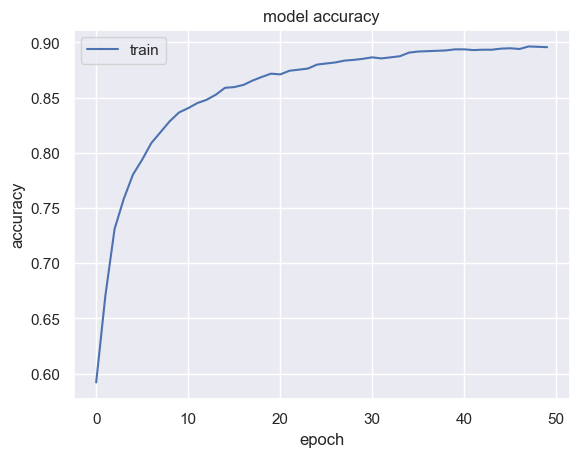

In [89]:
plt.plot(history_1.history['accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()

As you can see from the chart above, our model converged on an accuracy of about 90%. Next we tried making a neural net with significantly less nodes to see if there was an impact.

Epoch 1/50
8/8 [==============================] - 1s 30ms/step - loss: 1.0946 - accuracy: 0.3006 - val_loss: 0.9519 - val_accuracy: 0.3432
Epoch 2/50
8/8 [==============================] - 0s 6ms/step - loss: 0.9925 - accuracy: 0.3167 - val_loss: 0.8747 - val_accuracy: 0.3639
Epoch 3/50
8/8 [==============================] - 0s 6ms/step - loss: 0.9132 - accuracy: 0.3427 - val_loss: 0.8162 - val_accuracy: 0.3994
Epoch 4/50
8/8 [==============================] - 0s 6ms/step - loss: 0.8519 - accuracy: 0.3844 - val_loss: 0.7727 - val_accuracy: 0.4527
Epoch 5/50
8/8 [==============================] - 0s 6ms/step - loss: 0.8051 - accuracy: 0.4318 - val_loss: 0.7391 - val_accuracy: 0.5207
Epoch 6/50
8/8 [==============================] - 0s 6ms/step - loss: 0.7676 - accuracy: 0.4850 - val_loss: 0.7131 - val_accuracy: 0.5444
Epoch 7/50
8/8 [==============================] - 0s 6ms/step - loss: 0.7385 - accuracy: 0.5321 - val_loss: 0.6921 - val_accuracy: 0.5976
Epoch 8/50
8/8 [=================

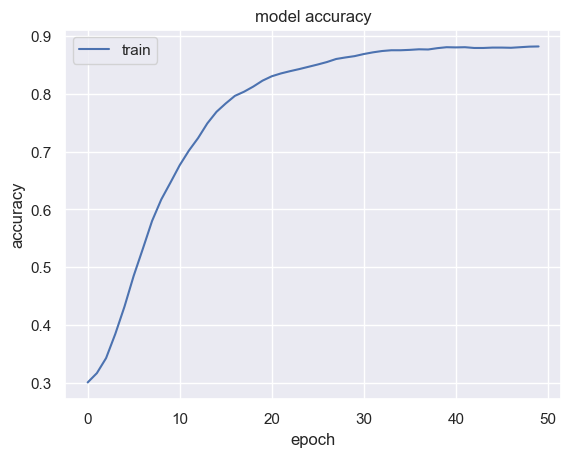

In [90]:
model_3 = Sequential()
model_3.add(Dense(16, input_dim=36))
model_3.add(LeakyReLU(alpha=0.05))
model_3.add(Dense(4, input_dim=16))
model_3.add(LeakyReLU(alpha=0.05))
model_3.add(Dense(1, activation='sigmoid'))

model_3.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
history_3 = model_3.fit(X_train, y_train, validation_split=0.1, epochs=50, batch_size=400)
y_pred = model_3.predict(X_test).flatten()
y_pred = (y_pred > 0.5).astype(int)
mse = np.mean((y_pred - y_test)**2)
print(mse)
errorGraph.append(mse)

plt.plot(history_3.history['accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()

As you can see from the graph, accuracy dipped incredibly slightly with this simplified architecture. Finally, we tried just adding one hidden layer of 8 nodes to see how our model would perform.

Epoch 1/50
8/8 [==============================] - 1s 25ms/step - loss: 0.6656 - accuracy: 0.6353 - val_loss: 0.6550 - val_accuracy: 0.6272
Epoch 2/50
8/8 [==============================] - 0s 6ms/step - loss: 0.6301 - accuracy: 0.6702 - val_loss: 0.6189 - val_accuracy: 0.6598
Epoch 3/50
8/8 [==============================] - 0s 7ms/step - loss: 0.5985 - accuracy: 0.6935 - val_loss: 0.5877 - val_accuracy: 0.6864
Epoch 4/50
8/8 [==============================] - 0s 7ms/step - loss: 0.5712 - accuracy: 0.7123 - val_loss: 0.5607 - val_accuracy: 0.7041
Epoch 5/50
8/8 [==============================] - 0s 6ms/step - loss: 0.5479 - accuracy: 0.7290 - val_loss: 0.5366 - val_accuracy: 0.7308
Epoch 6/50
8/8 [==============================] - 0s 7ms/step - loss: 0.5268 - accuracy: 0.7465 - val_loss: 0.5166 - val_accuracy: 0.7604
Epoch 7/50
8/8 [==============================] - 0s 7ms/step - loss: 0.5085 - accuracy: 0.7583 - val_loss: 0.4997 - val_accuracy: 0.7604
Epoch 8/50
8/8 [=================

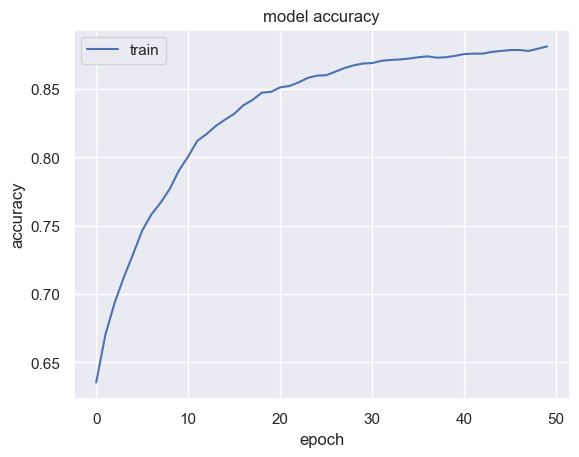

In [91]:
model_4 = Sequential()
model_4.add(Dense(8, input_dim=36))
model_4.add(LeakyReLU(alpha=0.05))
model_4.add(Dense(1, activation='sigmoid'))

model_4.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
history_4 = model_4.fit(X_train, y_train, validation_split=0.1, epochs=50, batch_size=400)
y_pred = model_4.predict(X_test).flatten()
y_pred = (y_pred > 0.5).astype(int)
mse = np.mean((y_pred - y_test)**2)
print(mse)
errorGraph.append(mse)

plt.plot(history_4.history['accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()

Surprisingly, this model still performed very well with about the same accuracy as the other two models. We also saved the errror from these three models which we can see did not change significantly.

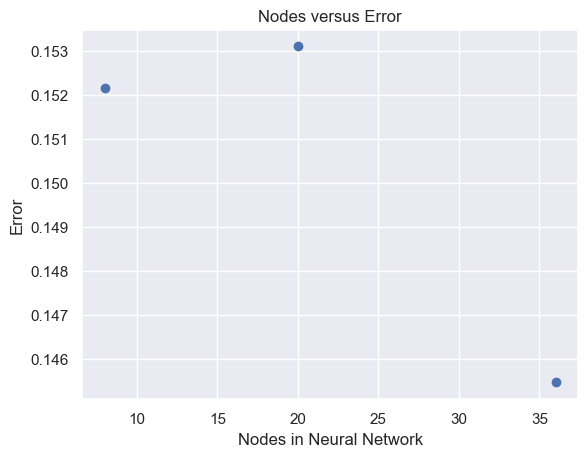

In [93]:
indices = [36, 20, 8]
fig, ax = plt.subplots()
ax.scatter(indices, errorGraph)
ax.set_xlabel('Nodes in Neural Network')
ax.set_ylabel('Error')
ax.set_title('Nodes versus Error')
plt.show()

As we can see, adding more nodes had a small impact on error driving it down by about 0.07 with the addition of more layers. However, this error is actually very small when compared to the linear regression model. Even with all 30 features where error was smallest at 0.16, the neural net with only 8 neurons performed better. 